# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](https://community.alteryx.com/t5/Data-Science/Beginner-s-Guide-to-Customer-Segmentation/ba-p/138442) by yhat. Please feel free to refer to the post for additional information, and solutions.

## Important links for learning:
https://community.alteryx.com/t5/Data-Science/Beginner-s-Guide-to-Customer-Segmentation/ba-p/138442
<br>
https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb
<br>
https://www.analyticsvidhya.com/blog/2021/05/k-mean-getting-the-optimal-number-of-clusters/

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

import warnings
warnings.filterwarnings('ignore')

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [4]:
#check for missing values
df_transactions.isnull().sum()
df_offers.isnull().sum()

offer_id     0
campaign     0
varietal     0
min_qty      0
discount     0
origin       0
past_peak    0
dtype: int64

Merge the data first and pivot to display the times each customer responded to the offers.

In [5]:
df = pd.merge(df_offers, df_transactions)
matrix = df.pivot_table(index=['customer_name'], columns=['offer_id'], values='n')
matrix.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN
Allen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
Anderson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Bailey,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
Baker,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


There are a lot of NaN values, so we'll replace them with '0' for a 0/1 categorical value.

In [6]:
matrix = matrix.fillna(0).reset_index()
matrix.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

Create a matrix 'x_cols' with just the column names.

In [7]:
x_cols = matrix.columns[1:]
x_cols

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
      dtype='object', name='offer_id')

Apply KMeans to the matrix and graph the SS for each K value.

In [8]:
# Import
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [9]:
# Create clusters and record SS to graph
SS=[]
k = range(2,11)
for num_clusters in k:
    cluster = KMeans(n_clusters=num_clusters)
    # Make sure we're only fitting for the offer ids
    cluster.fit(matrix[x_cols])
    # Append to SS
    SS.append(cluster.inertia_)
SS

[252.1146626078133,
 227.8736764705882,
 215.97927170868348,
 204.33876050420167,
 194.98448773448771,
 185.59953703703707,
 176.94914860681112,
 174.4412293588764,
 166.83978295096713]

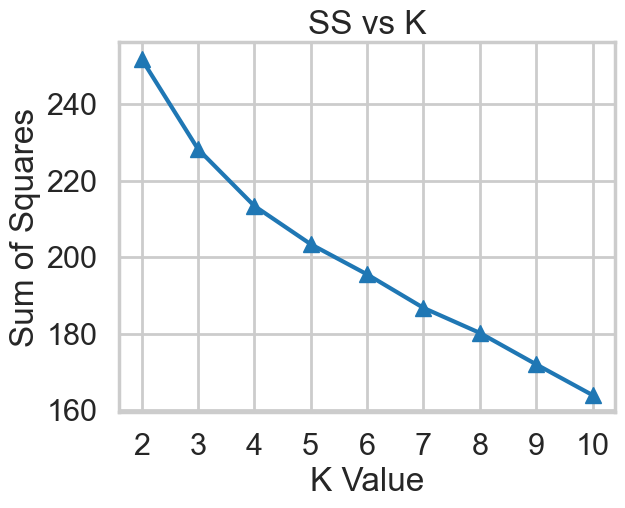

In [10]:
# Plot SS vs. K
plt.plot(k, SS, '-^')
plt.ylabel('Sum of Squares')
plt.xlabel('K Value')
plt.title('SS vs K')
plt.xticks(k);

It isn't especially clear which K value is at the elbow. This is a challenge with the elbow method, as data with less clear grouping can result in a less clear best K value. We are also checking this visually, which can have many arbitrary factors as well.
<br><br>
For now, let's choose a K value of 5, as it seems to be slowing down at somewhere between 4 and 5. 

In [10]:
# New cluster with K=5
cluster = KMeans(n_clusters=5)
matrix['cluster_5'] = cluster.fit_predict(matrix[x_cols])
matrix.cluster_5.value_counts()

2    32
0    25
3    17
4    14
1    12
Name: cluster_5, dtype: int64

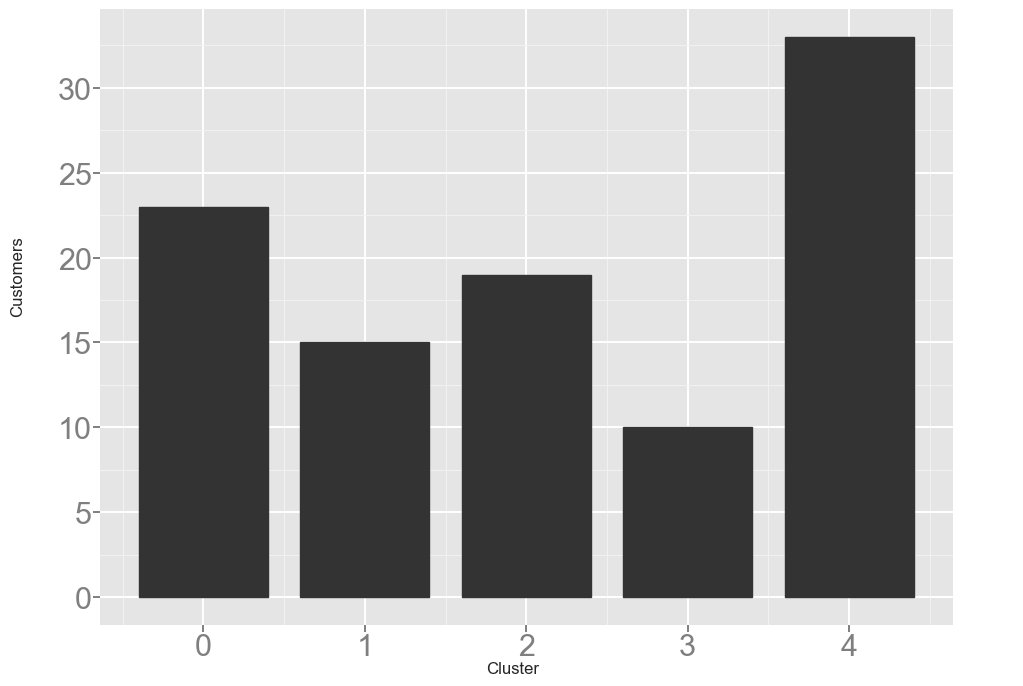

<ggplot: (112303982307)>

In [12]:
# Graph the results
from ggplot import *
ggplot(matrix, aes(x='cluster_5')) + geom_bar() + xlab("Cluster") + ylab("Customers");

Again, using the elbow method could be slightly problematic, as we can only visually confirm that k=5 is a good amount to use. Especially with this dataset, the elbow is not as easy to see, and finding an optimal k value could be improved using a different method.

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

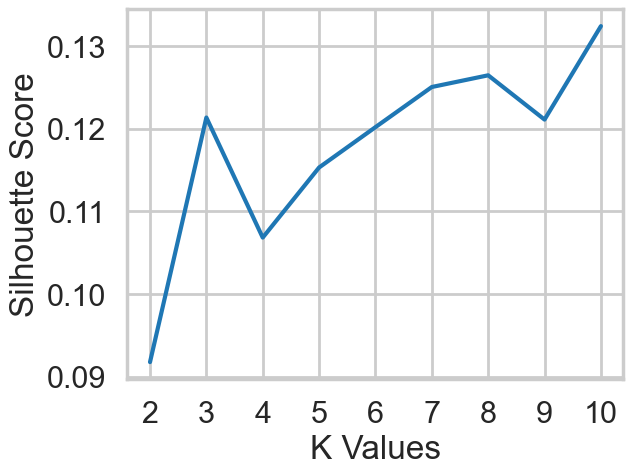

In [13]:
silhouette = []
k = list(k)
for num_clusters in k:
    sil_cluster = KMeans(n_clusters=num_clusters)
    sil_cluster.fit(matrix[x_cols])
    cluster_labels = sil_cluster.labels_
    silhouette.append(silhouette_score(matrix[x_cols], cluster_labels))
plt.plot(k, silhouette)
plt.xlabel('K Values')
plt.xticks(k)
plt.ylabel('Silhouette Score');

The best K value according to the Silhouette score is K=6, as it has the maximum score. An important note to pay attention to is that all of the scores are low (<0.2!). This means that our data potentially didn't cluster well, also explaining the lack of a clear elbow previously.
<br><br>
All in all, the silhouette score suggests a <b>K=10</b> as the best k value.

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [11]:
from sklearn.decomposition import PCA

In [12]:
# predict clusters and save to matrix
matrix['cluster'] = cluster.fit_predict(matrix[x_cols])

# initialize model
pca_cluster = PCA(n_components=2)
matrix['x'] = pca_cluster.fit_transform(matrix[x_cols])[:,0]
matrix['y'] = pca_cluster.fit_transform(matrix[x_cols])[:,1]
matrix = matrix.reset_index()

customers = matrix[['customer_name', 'cluster', 'x', 'y']]
customers.head()

offer_id,customer_name,cluster,x,y
0,Adams,2,1.007580,0.108215
1,Allen,3,-0.287539,0.044715
2,Anderson,4,-0.392032,1.038391
3,Bailey,2,0.699477,-0.022542
4,Baker,3,0.088183,-0.471695


Now, let's create a scatterplot with the x and y values, and take a look at the clusters we can see. First, we should merge this new dataframe 'customers' back into the original data with transactions and offers.

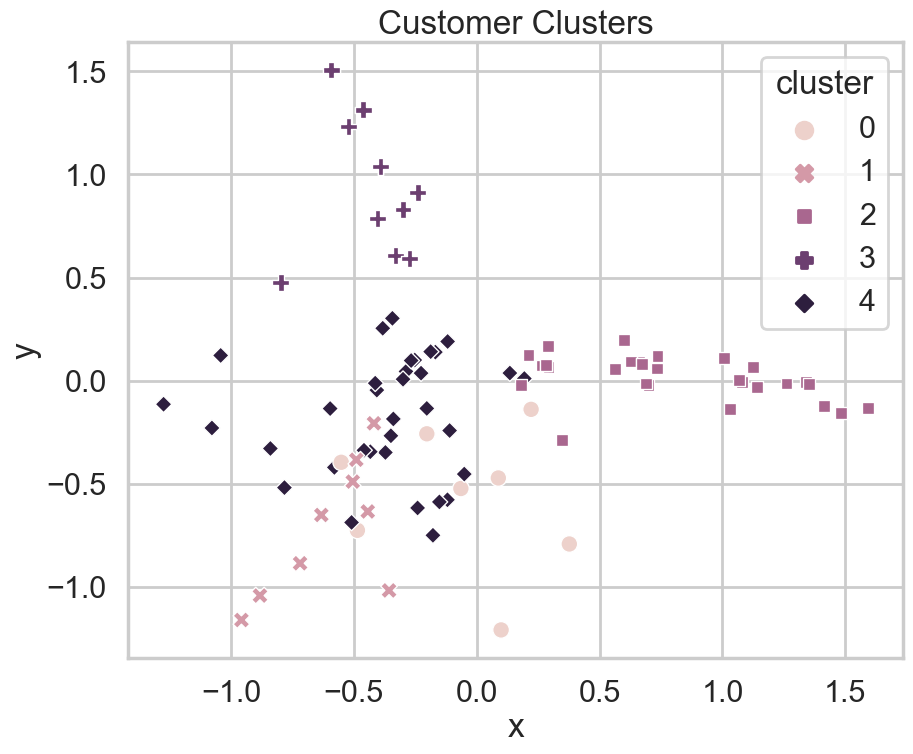

In [31]:
plt.figure(figsize=(10,8))
sns.scatterplot(x=customers.x,y=customers.y,data=customers, hue='cluster', style='cluster')
plt.title('Customer Clusters');

As shown by both the graph and previous two methods, it is not especially clear where the clusters should be. Visually, it does seem like there could be 4-6 clusters, but it is not easy to tell! 

### Let's try to look closer at some clusters and see if there is anything interesting.
I wil explore cluster 2, as it seems relatively distinct from the other clusters.
<br> We first need to append the clustered data to the original dataset so that we can actually analyze based on the customer information.

In [13]:
# merge customers back into the df
df = pd.merge(df_transactions, customers)
df = pd.merge(df_offers, df)
df.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n,cluster,x,y
0,1,January,Malbec,72,56,France,False,Thomas,1,0,-1.041879,0.122314
1,1,January,Malbec,72,56,France,False,Jackson,1,0,-0.839578,-0.328823
2,1,January,Malbec,72,56,France,False,Mitchell,1,0,-0.342938,0.302186
3,1,January,Malbec,72,56,France,False,Peterson,1,0,-0.797379,0.475995
4,1,January,Malbec,72,56,France,False,Wood,1,0,-0.551215,-0.395670


In [16]:
df['cluster_2'] = df.cluster==2
df.groupby("cluster_2").varietal.value_counts()

cluster_2  varietal          
False      Champagne             79
           Pinot Noir            44
           Prosecco              31
           Cabernet Sauvignon    30
           Espumante             20
           Chardonnay            14
           Malbec                13
           Merlot                12
           Pinot Grigio           4
True       Espumante             20
           Malbec                19
           Pinot Grigio          13
           Prosecco              12
           Merlot                 8
           Cabernet Sauvignon     2
           Champagne              2
           Chardonnay             1
Name: varietal, dtype: int64

It is not entirely clear why the groupings occur with just the True and False of cluster_2. We see some overlap in wine types despite being in opposing groups! Let's also look at the discount and min_qty of the purchases to see if there is more information there.

In [17]:
df.groupby("cluster_2")[['min_qty', 'discount']].mean()

,min_qty,discount
cluster_2,,
False,72.582996,60.514170
True,12.935065,56.168831


Comparing to a different cluster, let's say, cluster 3...

In [18]:
df['cluster_3'] = df.cluster==3
df.groupby("cluster_3").varietal.value_counts()

cluster_3  varietal          
False      Champagne             44
           Pinot Noir            44
           Malbec                32
           Prosecco              27
           Espumante             23
           Cabernet Sauvignon    15
           Merlot                14
           Pinot Grigio          13
           Chardonnay             8
True       Champagne             37
           Cabernet Sauvignon    17
           Espumante             17
           Prosecco              16
           Chardonnay             7
           Merlot                 6
           Pinot Grigio           4
Name: varietal, dtype: int64

In [19]:
df.groupby("cluster_3")[['min_qty', 'discount']].mean()

,min_qty,discount
cluster_3,,
False,55.145455,57.795455
True,65.307692,63.048077


We can see by looking at the two clusters, that there are clear differences between the purchasing styles! For example:
<br> 1. Cluster 3 clearly has an affinity towards 'Pinot Noir'
<br> 2. Cluster 2 nearly always only purchases a minimum quantity of 10.
<br> 3. Cluster 3, on the other hand, is more willing to purchase more wine, despite perhaps getting a smaller discount.
<br><br>
In other words, we can tell that Cluster 2 has a bigger focus on <b>*purchase size*</b>, while Cluster 3 focuses on a <b>*specific kind of wine*</b>.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

In [20]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(matrix[x_cols])

PCA()

In [21]:
import numpy as np
# find eigenvalues and proportion of explained variance values first
eigenvalues = pca.explained_variance_
prop_var = eigenvalues / np.sum(eigenvalues)

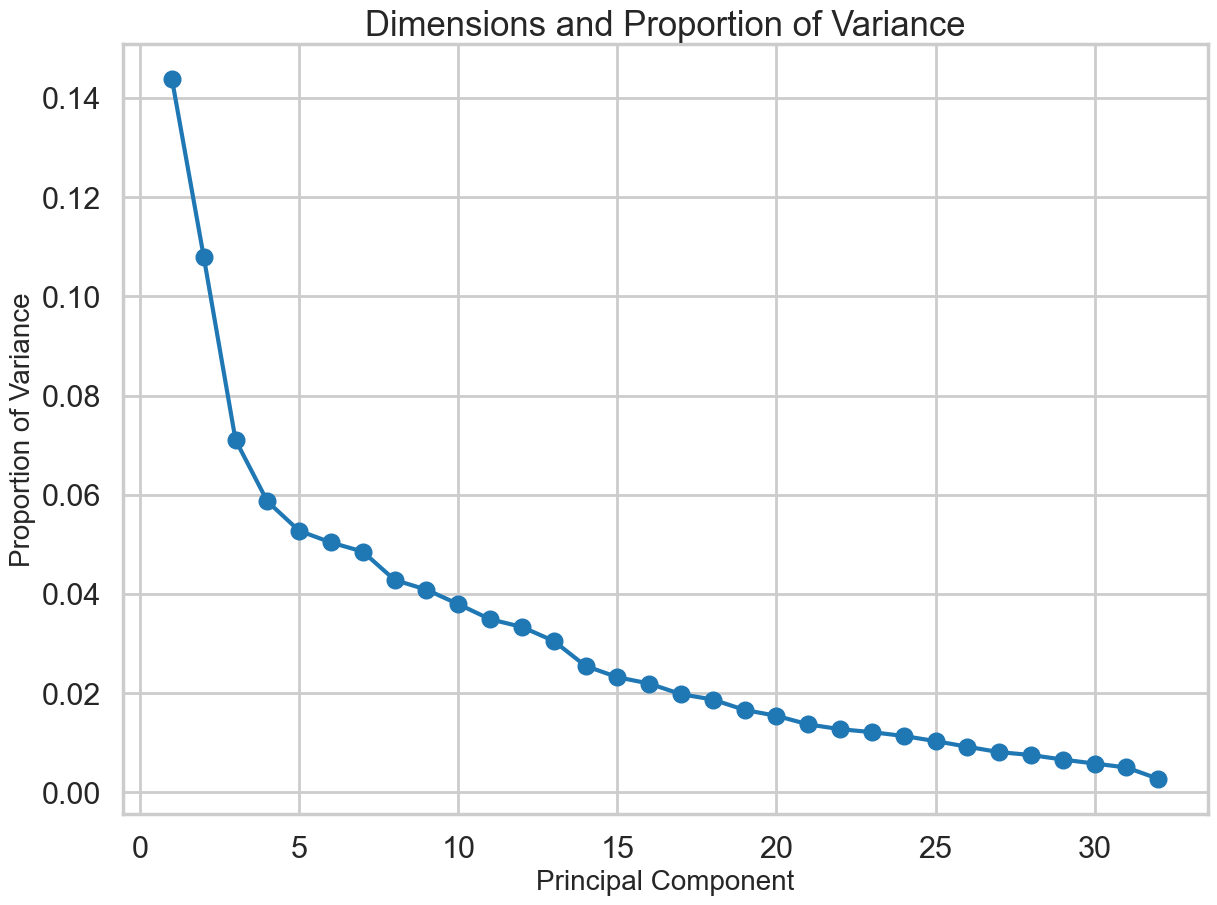

In [44]:
plt.figure(figsize=(14,10))
plt.plot(np.arange(1, len(prop_var)+1), 
                   prop_var, marker='o')
plt.xlabel('Principal Component',
           size = 20)
plt.ylabel('Proportion of Variance',
           size = 20)
plt.title('Dimensions and Proportion of Variance',
          size = 25)
plt.grid(True)

We can see a clear elbow occuring at around <b>dimension 5<b/>! This is a potential optimal dimension to use in pca.

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


## Let's try some other clustering algorithms
### 1. Affinity Propagation

In [22]:
# Affinity Propagation Algorithm
from sklearn.cluster import AffinityPropagation
affcluster = AffinityPropagation(random_state=5)
matrix['Affinity_Cluster'] = affcluster.fit_predict(matrix[x_cols])

To see how effective this form of clustering has been, let's visualize the clusters using PCA again!

In [23]:
# use PCA again to create new cluster plot using Affinity clusters
customers2 = matrix[['customer_name', 'Affinity_Cluster', 'x', 'y']]
customers2.head()

offer_id,customer_name,Affinity_Cluster,x,y
0,Adams,0,1.007580,0.108215
1,Allen,10,-0.287539,0.044715
2,Anderson,6,-0.392032,1.038391
3,Bailey,3,0.699477,-0.022542
4,Baker,3,0.088183,-0.471695


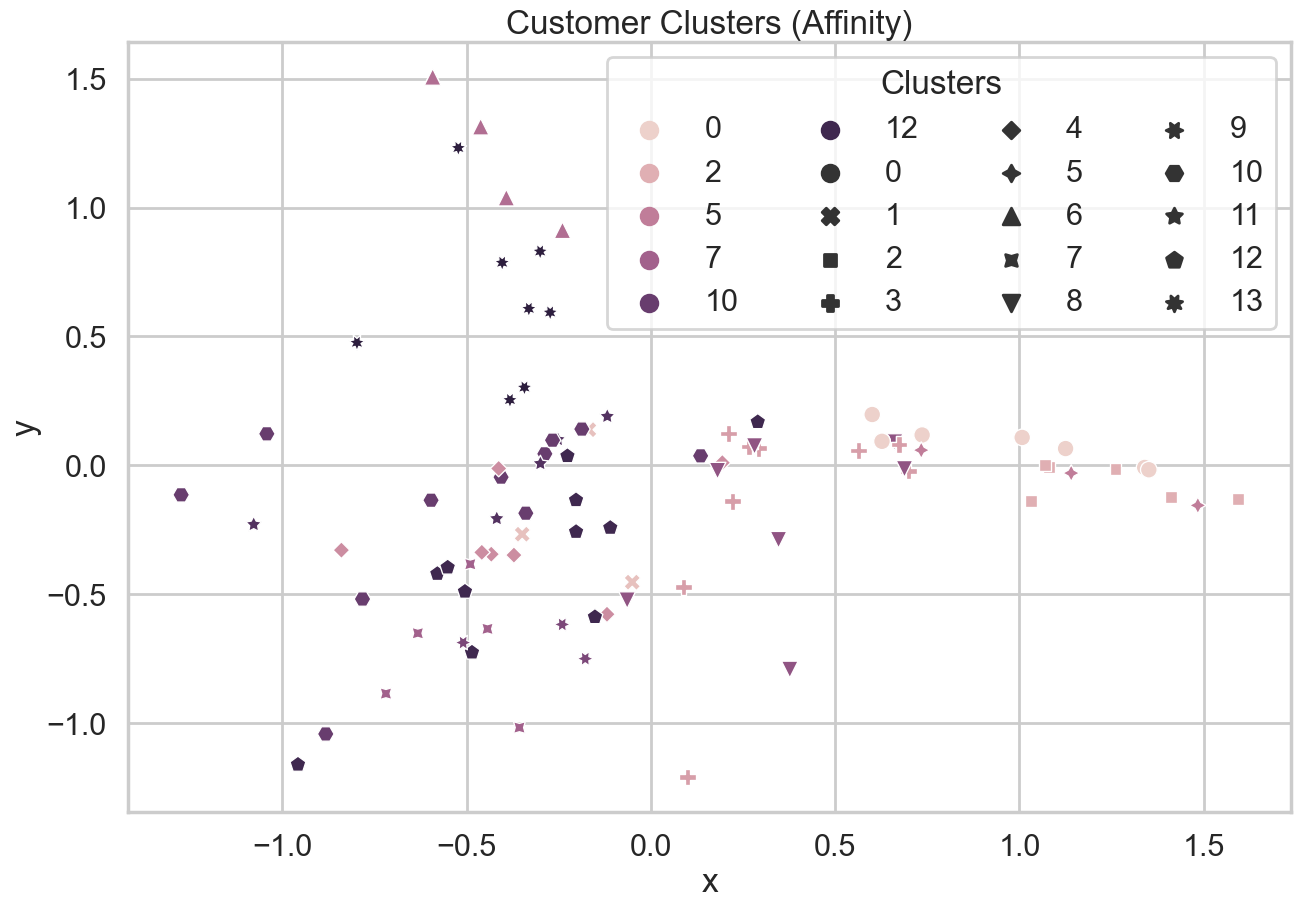

In [32]:
plt.figure(figsize=(15,10))
sns.scatterplot(x=customers.x,y=customers.y,data=customers2, hue='Affinity_Cluster', style='Affinity_Cluster')
plt.legend(loc='best', ncols=4, title='Clusters')
plt.title('Customer Clusters (Affinity)');

Clusters are a bit muddled! Perhaps there are too many clusters using this method.
### 2. Spectral Clustering 

In [33]:
from sklearn.cluster import SpectralClustering

With spectral clustering, we need to specify the cluster number from the start. Let's try with 5 clusters, as we also used that for KMeans!

In [34]:
# Initialize clusters
sc = SpectralClustering(5)
matrix['Spectral_Cluster'] = sc.fit_predict(matrix[x_cols])

Once again, we can visualize the effectiveness of this clustering using PCA.

In [35]:
# use PCA again to create new cluster plot using Spectral clusters
customers3 = matrix[['customer_name', 'Spectral_Cluster', 'x', 'y']]
customers3.head()

offer_id,customer_name,Spectral_Cluster,x,y
0,Adams,3,1.007580,0.108215
1,Allen,1,-0.287539,0.044715
2,Anderson,4,-0.392032,1.038391
3,Bailey,3,0.699477,-0.022542
4,Baker,1,0.088183,-0.471695


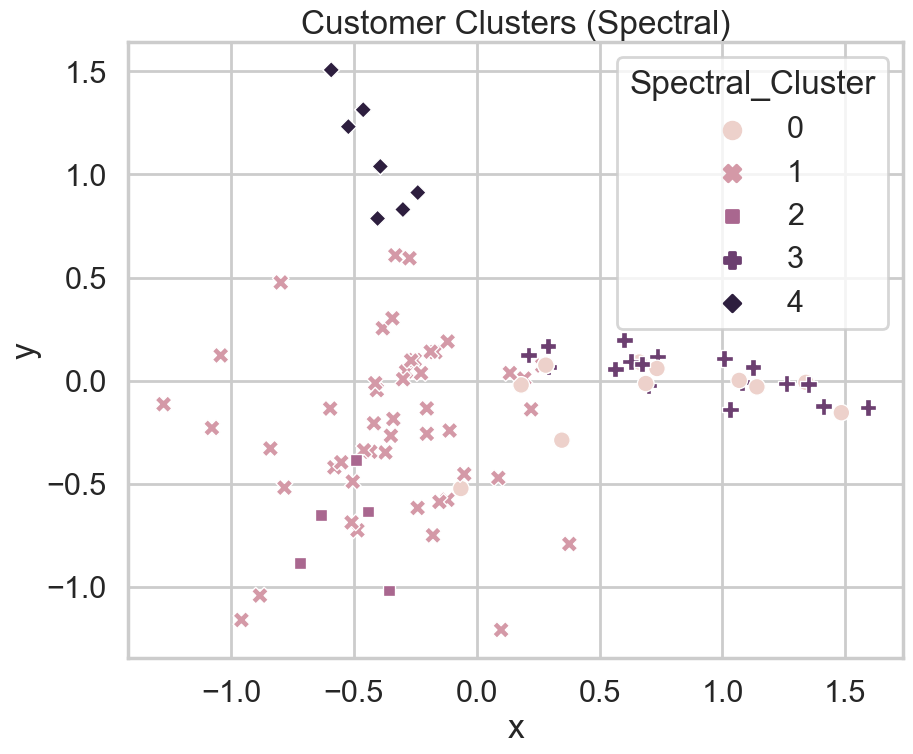

In [46]:
plt.figure(figsize=(10,8))
sns.scatterplot(x=customers3.x,y=customers3.y,data=customers3, hue='Spectral_Cluster', style='Spectral_Cluster')
plt.title('Customer Clusters (Spectral)');

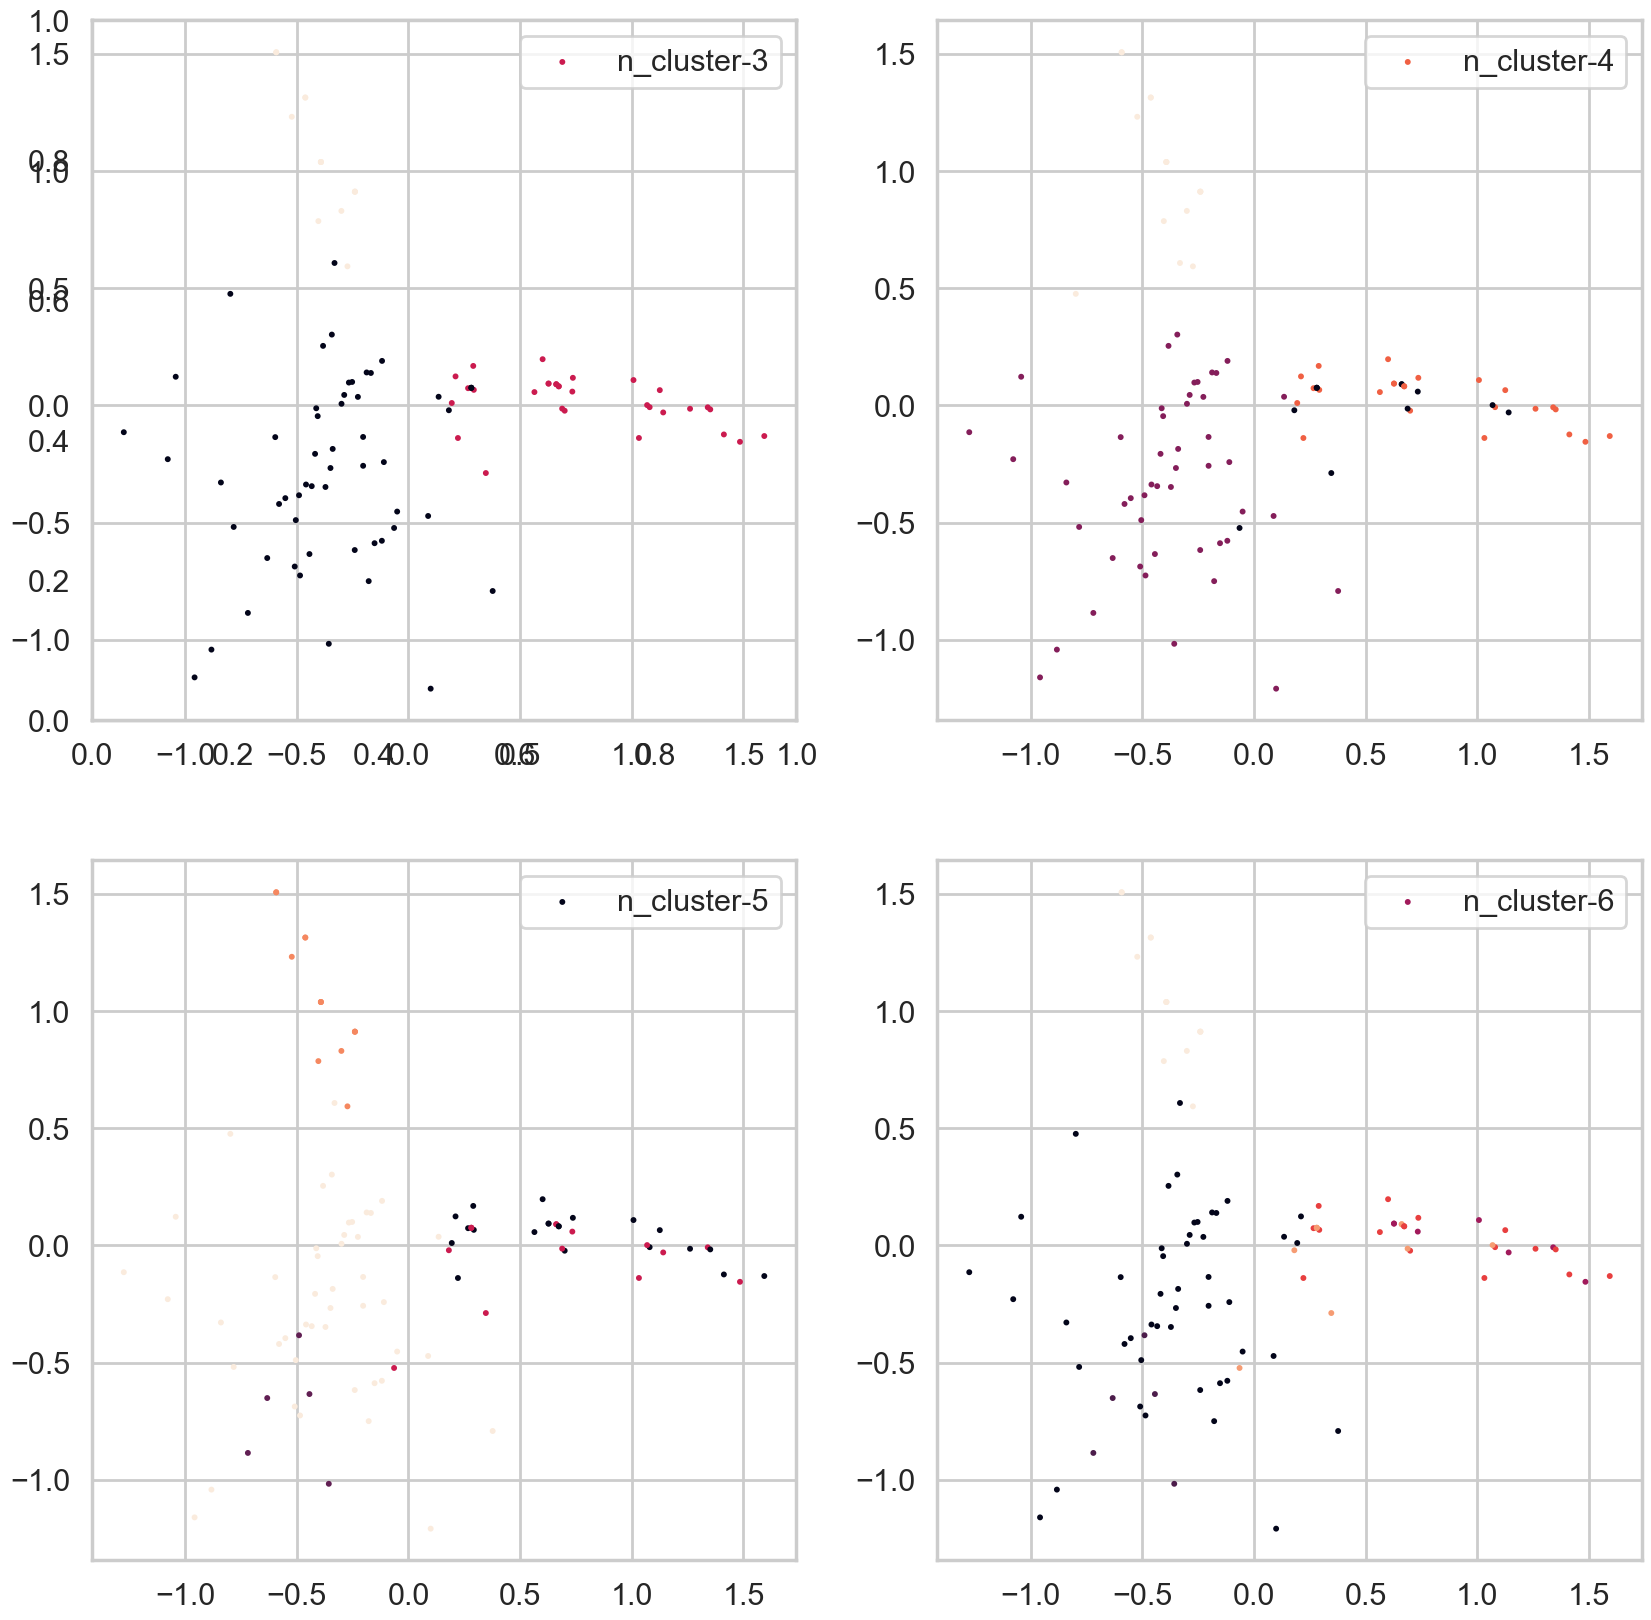

In [51]:
f = plt.figure(figsize=(20,20))
f.add_subplot(2, 2, 1)
for i in range(3, 7):
 sc = SpectralClustering(n_clusters=i)
 matrix['Spectral_Cluster'] = sc.fit_predict(matrix[x_cols])
 temp = matrix[['customer_name', 'Spectral_Cluster', 'x', 'y']]
 f.add_subplot(2, 2, i-2)
 plt.scatter(customers.x, customers.y, s=5, c=temp['Spectral_Cluster'], label="n_cluster-"+str(i))
 plt.legend()

plt.show() 

We can see the clustering of a few different K values. However, the clusters are a bit mingled and are not necessarily better than previous methods.

### Agglomerative Clustering

In [53]:
from sklearn.cluster import AgglomerativeClustering

In [58]:
# Initialize clusters
agg_cluster = AgglomerativeClustering(distance_threshold=1, n_clusters=None)
matrix['Agglomerative_Cluster'] = agg_cluster.fit_predict(matrix[x_cols])

In [59]:
# use PCA again to create new cluster plot using Agg clusters
customers4 = matrix[['customer_name', 'Agglomerative_Cluster', 'x', 'y']]
customers4.head()

offer_id,customer_name,Agglomerative_Cluster,x,y
0,Adams,88,1.007580,0.108215
1,Allen,87,-0.287539,0.044715
2,Anderson,10,-0.392032,1.038391
3,Bailey,86,0.699477,-0.022542
4,Baker,57,0.088183,-0.471695


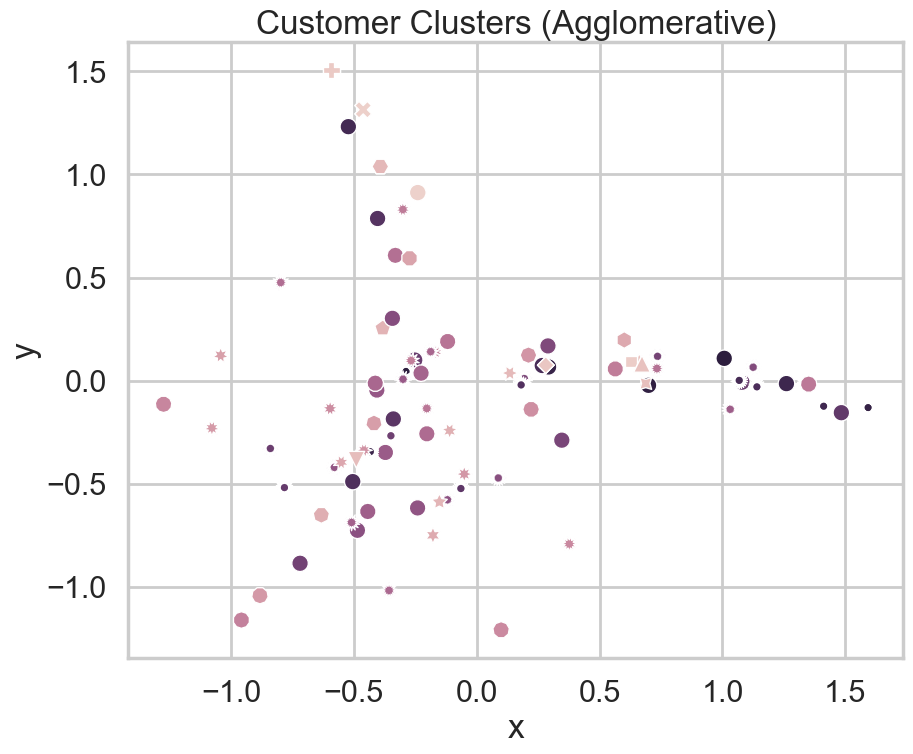

In [64]:
plt.figure(figsize=(10,8))
sns.scatterplot(x=customers.x,y=customers.y,data=customers4, hue='Agglomerative_Cluster', style='Agglomerative_Cluster')
plt.legend([], [], frameon=False)
plt.title('Customer Clusters (Agglomerative)');

Agglomerative Clustering has the benefit of being able to handle *A LOT* of clusters. In this example, I set the distance threshold to 1, and as you can see, there are quite a few different clusters. The above dataframe includes cluster values up to 88!

Alternatively, we can try setting a number of clusters, though this will be much more similar to some of the other algorithms we used above.

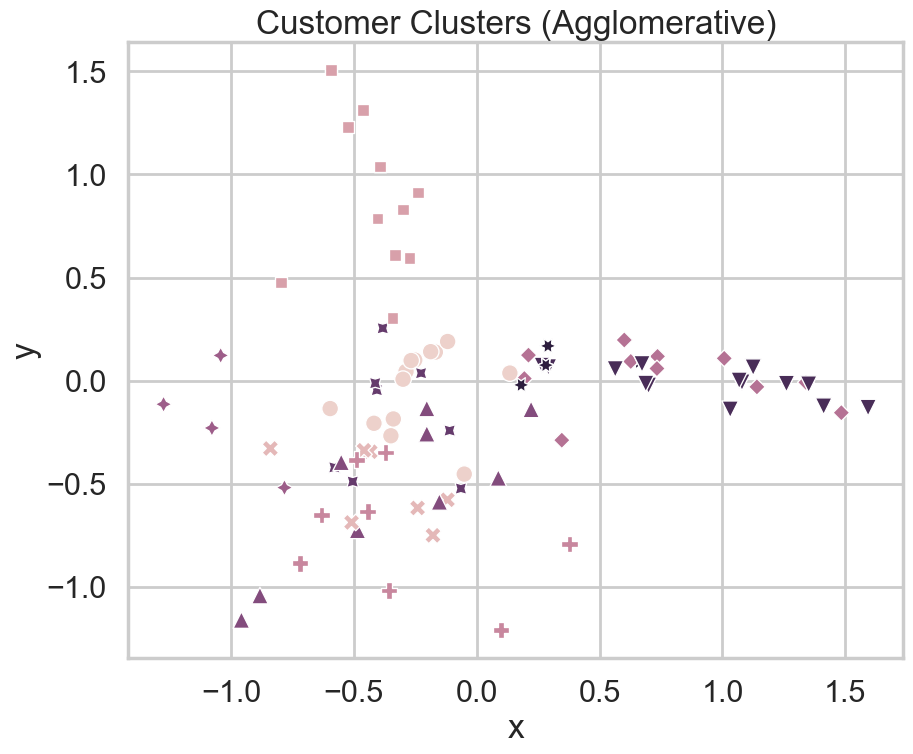

In [68]:
# Repeat process, but with cluster=10
agg_cluster = AgglomerativeClustering(distance_threshold=None, n_clusters=10)
matrix['Agglomerative_Cluster'] = agg_cluster.fit_predict(matrix[x_cols])
customers4 = matrix[['customer_name', 'Agglomerative_Cluster', 'x', 'y']]
plt.figure(figsize=(10,8))
sns.scatterplot(x=customers.x,y=customers.y,data=customers4, hue='Agglomerative_Cluster', style='Agglomerative_Cluster')
plt.legend([], [], frameon=False)
plt.title('Customer Clusters (Agglomerative)');

There are many parameters to tune in Agglomerative Clustering, but above is just the result of using the most basic model. Other areas to explore include optimizing the cluster count or distance, and choosing a linkage type.

### DBSCAN

In [69]:
from sklearn.cluster import DBSCAN

For DBSCAN, we need to include a maximum distance between samples to be considered neighbors. We will set this value 'eps' to 1 and see how it looks first!

In [70]:
# initialize clusters
db = DBSCAN(eps=1)
matrix['DBSCAN'] = db.fit_predict(matrix[x_cols])

In [71]:
# use PCA again to create new cluster plot using Agg clusters
customers5 = matrix[['customer_name', 'DBSCAN', 'x', 'y']]
customers5.head()

offer_id,customer_name,DBSCAN,x,y
0,Adams,0,1.007580,0.108215
1,Allen,-1,-0.287539,0.044715
2,Anderson,1,-0.392032,1.038391
3,Bailey,2,0.699477,-0.022542
4,Baker,-1,0.088183,-0.471695


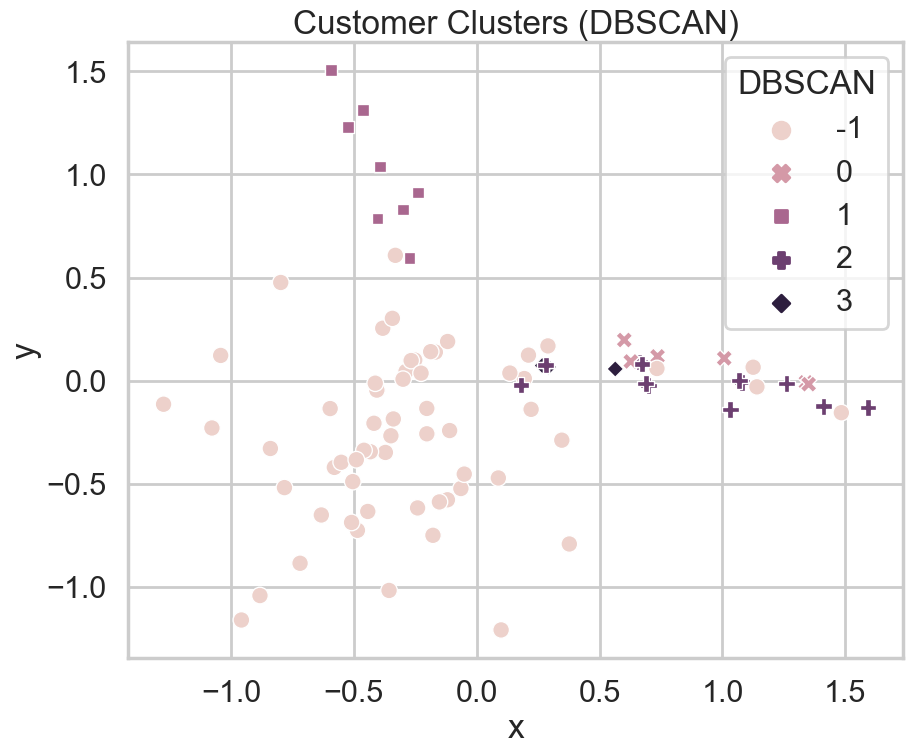

In [72]:
plt.figure(figsize=(10,8))
sns.scatterplot(x=customers.x,y=customers.y,data=customers5, hue='DBSCAN', style='DBSCAN')
plt.title('Customer Clusters (DBSCAN)');

To further specialize the clusters, we can fiddle with the maximum neighbor distance. For now, we're using eps=1 and it results in 3 clusters, as shown above.

## Conclusion
After trying out the 5 clustering algorithms above (KMeans, Affinity, Spectral, Agglomerative, and DBSCAN), we can see distinct similarities and difference between each method! Several methods ask for a cluster count, meaning you can optimize clusters using the Elbow Method or the Silhouette Method, as explored earlier. 
<br>
Other algorithms use alternative parameters, and have strengths in different data sizes, different cluster amounts, varying data, etc.
<br><br>
Overall, I personally thought <b>Agglomerative clustering</b> was the most flexible, as it allowed for optimization in *both* cluster count and distance threshold. It also works with many clusters, allowing the user to work with large and varied datasets! As a runner up useful algorithm, the first algorithm we explored, KMeans, was overall very simple and flexible to use in most clustering cases. 